In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, datasets

In [2]:
from tensorflow.keras.models import load_model

# Load the unprotected model from the .h5 file
model = load_model('PlayingCard.h5')

In [3]:
# Load the dataset to allow for adversarial image generation
# CHANGE USERNAME WHEN WORKING BETWEEN LAPTOP AND DESKTOP!!

import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_dataset(base_dir, target_size=(224, 224)):
    images = []
    labels = []
    class_labels = {'hearts': 0, 'diamonds': 1, 'clubs': 2, 'spades': 3}
    
    # Navigate through each suit folder
    for suit in class_labels.keys():
        suit_dir = os.path.join(base_dir, suit)
        print(f"Checking suit directory: {suit_dir}")  # Debug print
        if os.path.isdir(suit_dir):
            label_index = class_labels[suit]
            print(f"Label index for {suit}: {label_index}")  # Debug print

            # Navigate through each card folder within the suit folder
            for card_folder in os.listdir(suit_dir):
                card_folder_path = os.path.join(suit_dir, card_folder)
                #print(f"Checking card folder: {card_folder_path}")  # Add this debug print
                if os.path.isdir(card_folder_path):
                    # Load each image from the card folder
                    for image_file in os.listdir(card_folder_path):
                        image_path = os.path.join(card_folder_path, image_file)
                        image = load_img(image_path, target_size=target_size)
                        #print(f"Loading image: {image_path}")  # Debug print
                        image_array = img_to_array(image)
                        images.append(image_array)
                        labels.append(label_index)
    
    # After loading all images and labels, shuffle them
    combined = list(zip(images, labels))
    np.random.shuffle(combined)

    images[:], labels[:] = zip(*combined)                    
    
    images = np.array(images, dtype='float32') / 255.0  # Normalize to [0, 1]
    labels = np.array(labels, dtype='int32')
    
    # Print some of the labels to verify they are correct
    print(labels[:100])
    
    return images, labels, class_labels

# Directory Definitions
base_dir = "c:\\Users\\alec\\OneDrive - University of North Georgia\\FALL 2023\\Cyber capstone\\Experimentation\\SortedData"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Usage
train_images, train_labels, train_class_labels = load_dataset(train_dir)
valid_images, valid_labels, valid_class_labels = load_dataset(validation_dir)
test_images, test_labels, test_class_labels = load_dataset(test_dir)

# Check shapes and class labels
print(train_images.shape, train_labels.shape)
print(valid_images.shape, valid_labels.shape)
print(test_images.shape, test_labels.shape)
print(train_class_labels)


Checking suit directory: c:\Users\alec\OneDrive - University of North Georgia\FALL 2023\Cyber capstone\Experimentation\SortedData\train\hearts
Label index for hearts: 0
Checking suit directory: c:\Users\alec\OneDrive - University of North Georgia\FALL 2023\Cyber capstone\Experimentation\SortedData\train\diamonds
Label index for diamonds: 1
Checking suit directory: c:\Users\alec\OneDrive - University of North Georgia\FALL 2023\Cyber capstone\Experimentation\SortedData\train\clubs
Label index for clubs: 2
Checking suit directory: c:\Users\alec\OneDrive - University of North Georgia\FALL 2023\Cyber capstone\Experimentation\SortedData\train\spades
Label index for spades: 3
[3 0 3 3 1 0 3 2 1 2 3 3 1 0 1 2 2 3 0 1 1 2 1 3 3 0 0 1 0 2 0 3 3 0 0 1 3
 0 0 0 0 0 1 0 2 2 3 1 2 1 0 0 0 1 3 3 3 2 0 2 3 1 0 1 3 1 0 0 0 1 3 0 3 3
 0 1 3 0 3 3 0 0 3 1 1 3 1 0 2 1 3 2 2 2 0 0 1 1 2 1]
Checking suit directory: c:\Users\alec\OneDrive - University of North Georgia\FALL 2023\Cyber capstone\Experimentation

In [4]:
#Reducing training dataset to prevent a recursion error
# Assuming train_images and train_labels are your full dataset

# Set a seed for reproducibility
np.random.seed(42)

# Randomly select 1000 indices without replacement
selected_indices = np.random.choice(train_images.shape[0], size=1000, replace=False)

# Subset the images and labels using the selected indices
reduced_train_images = train_images[selected_indices]
reduced_train_labels = train_labels[selected_indices]


In [5]:
train_images.shape

(7509, 224, 224, 3)

In [6]:
import tensorflow as tf

epsilon = 0.01  # Perturbation amount
input_shape = (224, 224, 3)

# Select a small subset of data for testing
subset_images = train_images[:10]
subset_labels = train_labels[:10]

# Convert to tensors
tensor_images = tf.convert_to_tensor(subset_images, dtype=tf.float32)
tensor_labels = tf.convert_to_tensor(subset_labels, dtype=tf.int32)

# Create the adversarial examples
with tf.GradientTape() as tape:
    tape.watch(tensor_images)
    predictions = model(tensor_images)
    loss = tf.keras.losses.sparse_categorical_crossentropy(tensor_labels, predictions)

# Calculate gradients
gradients = tape.gradient(loss, tensor_images)

# Create the adversarial examples by applying the perturbation
adversarial_examples = tensor_images + epsilon * tf.sign(gradients)
adversarial_examples = tf.clip_by_value(adversarial_examples, 0, 1)  # Ensure values are still in [0, 1] range


In [7]:
# Convert the reduced train_images and train_labels to tensors
reduced_tensor_images = tf.convert_to_tensor(reduced_train_images, dtype=tf.float32)
reduced_tensor_labels = tf.convert_to_tensor(reduced_train_labels, dtype=tf.int32)

# Create adversarial examples for the full dataset
with tf.GradientTape() as tape:
    tape.watch(reduced_tensor_images)
    predictions = model(reduced_tensor_images)
    loss = tf.keras.losses.sparse_categorical_crossentropy(reduced_tensor_labels, predictions)

# Calculate gradients
gradients = tape.gradient(loss, reduced_tensor_images)

# Create the adversarial examples by applying the perturbation
adversarial_images = reduced_tensor_images + epsilon * tf.sign(gradients)
adversarial_images = tf.clip_by_value(adversarial_images, 0, 1)


In [8]:
# Calculate the number of adversarial and original images
num_adversarial = int(len(reduced_train_images))
num_original = len(train_images) - num_adversarial
print(num_adversarial)

# Select adversarial and original images
selected_adversarial_images = adversarial_images[:num_adversarial]
selected_original_images = train_images[num_adversarial:]

# Combine them
combined_images = np.concatenate([selected_adversarial_images, selected_original_images], axis=0)
combined_labels = np.concatenate([train_labels[:num_adversarial], train_labels[num_adversarial:]], axis=0)

# Shuffle the combined dataset
indices = np.arange(combined_images.shape[0])
np.random.shuffle(indices)

#combined_images = combined_images.numpy()[indices]  # Convert tensors to numpy arrays if necessary
#combined_labels = combined_labels.numpy()[indices]


1000


In [9]:
# Retrain the model with the combined dataset
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(combined_images, combined_labels, epochs=10, validation_data=(valid_images, valid_labels))


Epoch 1/10
235/235 [==============================] - 170s 721ms/step - loss: 0.8108 - accuracy: 0.7942 - val_loss: 0.2895 - val_accuracy: 0.9538
Epoch 2/10
235/235 [==============================] - 170s 723ms/step - loss: 0.6763 - accuracy: 0.8222 - val_loss: 0.2712 - val_accuracy: 0.9615
Epoch 3/10
235/235 [==============================] - 170s 721ms/step - loss: 0.6175 - accuracy: 0.8349 - val_loss: 0.2342 - val_accuracy: 0.9808
Epoch 4/10
235/235 [==============================] - 170s 723ms/step - loss: 0.5562 - accuracy: 0.8490 - val_loss: 0.1962 - val_accuracy: 0.9577
Epoch 5/10
235/235 [==============================] - 170s 725ms/step - loss: 0.5135 - accuracy: 0.8604 - val_loss: 0.1975 - val_accuracy: 0.9654
Epoch 6/10
235/235 [==============================] - 171s 726ms/step - loss: 0.4774 - accuracy: 0.8652 - val_loss: 0.1398 - val_accuracy: 0.9692
Epoch 7/10
235/235 [==============================] - 170s 724ms/step - loss: 0.4493 - accuracy: 0.8699 - val_loss: 0.2062 -

In [13]:
print(combined_images.shape)
print(combined_labels.shape)

(5006, 224, 224, 3)
(7509,)


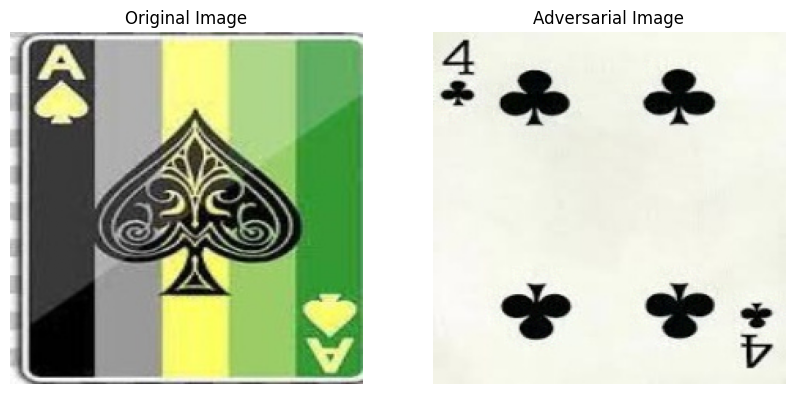

In [14]:
import matplotlib.pyplot as plt

def display_adversarial_images(original_images, adversarial_images, index):
    plt.figure(figsize=(10, 5))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_images[index])
    plt.title("Original Image")
    plt.axis('off')

    # Display adversarial image
    plt.subplot(1, 2, 2)
    adversarial_image = np.clip(adversarial_images[index], 0, 1)  # Clip to [0, 1] to display correctly
    plt.imshow(adversarial_image)
    plt.title("Adversarial Image")
    plt.axis('off')

    plt.show()

# Choose an index to visualize
index_to_visualize = 3  # Can be any valid index of the dataset

# Display train_images and adversarial_images
display_adversarial_images(train_images, adversarial_images.numpy(), index_to_visualize)